In [1]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FS = 44100 #sampling frequency

In [3]:
def create_t(length_seconds):
    return np.linspace(0, length_seconds, int(FS*length_seconds))

In [4]:
bitT = 0.01

In [5]:
S0 = np.sin(create_t(bitT)*2*np.pi* 1300)
S1 = np.sin(create_t(bitT)*2*np.pi*1700)

In [6]:
synT = create_t(bitT*10)
synS = np.cos(synT*2*np.pi*1500)

In [7]:
get_pulse = {'0':S0, '1':S1}

In [8]:
STR = "Hello, world"

In [9]:
def str2bits(str):
    res = bin(int.from_bytes(str.encode('ascii'), 'big'))[2:]
    return '0'*(8 - (len(res) % 8)) + res

In [10]:
r = str2bits(STR)

In [11]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [12]:
def send(binstream):
    SigLen = S0.size
    n = len(binstream)
    S = np.empty(n*SigLen + synS.size)
    c = 0
    S[:synS.size] = synS
    for b in binstream:
        S[c*SigLen + synS.size:(c+1)*SigLen + synS.size] = get_pulse[b]
        c+=1 
    return S

In [13]:
W = send(r)

In [14]:
%%time
np.correlate(W, synS, 'valid')

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 42.7 ms


array([ 2.20550000e+03,  2.15432495e+03,  2.00531338e+03, ...,
        4.70174331e+00,  2.39977527e+00, -7.14398093e-02])

In [15]:
def decode(W):
    corr = np.correlate(W, synS, 'valid')
    start_syn = np.argmax(corr)
    start = start_syn + synS.size
    result = ''
    rlen = int((W.size)/(bitT*FS))
    for i in range(len(STR)*8):
        symStart = start + int(i*bitT*FS)
        symEnd = symStart + int(bitT*FS)
        S0max = np.max(np.correlate(W[symStart:symEnd], S0[:S0.size//2]))
        S1max = np.max(np.correlate(W[symStart:symEnd], S1[:S1.size//2]))
        result += '0' if S0max > S1max else '1'
    return result

In [16]:
decode(np.hstack((np.random.normal(0, 1, 1050), W, np.random.normal(0,1, 1000))))

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [17]:
r

'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [18]:
r == decode(W)

True

In [19]:
%%time
decode(W)

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 48.6 ms


'010010000110010101101100011011000110111100101100001000000111011101101111011100100110110001100100'

In [20]:
sigma = 1
Wnoise = W + np.random.normal(0, sigma, W.size)
decode(Wnoise) == r

True

In [33]:
col_noise = bandpass_noise(1, 100)

In [32]:
#generate colored white noise
from scipy.fftpack import rfft, irfft, fftfreq

def bandpass_noise(sigma_pass, sigma_out):
    white_noise = np.random.normal(0, 1, W.size)

    freq = fftfreq(white_noise.size, d = 1/FS)
    f_wnoise = rfft(white_noise)

    # If our original signal time was in seconds, this is now in Hz
    out_of_band_mask = np.logical_or(np.logical_and(freq < 2000, freq > 1000), np.logical_and(freq > -2000,freq < -1000))
    in_band_mask = np.logical_not(out_of_band_mask)
    f_wnoise[out_of_band_mask] *= sigma_out
    f_wnoise[in_band_mask] *= sigma_pass
    return irfft(f_wnoise)

In [108]:
decode(W*0.1 + bandpass_noise(0.1, 4)) == r

False

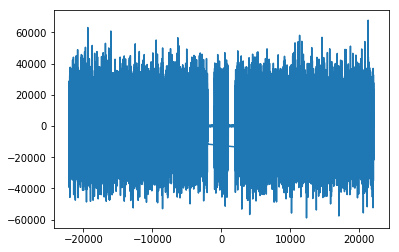

In [29]:
plt.plot(fftfreq(W.size, d = 1/FS), rfft(col_noise))

In [97]:
sd.play(W*0.1 + bandpass_noise(0.1, 2), FS)

-1.0

In [87]:
help(sd.play)

Help on function play in module sounddevice:

play(data, samplerate=None, mapping=None, blocking=False, loop=False, **kwargs)
    Play back a NumPy array containing audio data.
    
    Parameters
    ----------
    data : array_like
        Audio data to be played back.  The columns of a two-dimensional
        array are interpreted as channels, one-dimensional arrays are
        treated as mono data.
        The data types *float64*, *float32*, *int32*, *int16*, *int8*
        and *uint8* can be used.
        *float64* data is simply converted to *float32* before passing
        it to PortAudio, because it's not supported natively.
    mapping : array_like, optional
        List of channel numbers (starting with 1) where the columns of
        *data* shall be played back on.  Must have the same length as
        number of channels in *data* (except if *data* is mono, in which
        case the signal is played back on all given output channels).
        Each channel number may only ap

In [ ]:
np.min(Wnoise)

In [ ]:
plt.plot(Wnoise[44000:45000])

In [ ]:
bitT = 1
np.sin(bitT/2*600)/(bitT/2*600)